In [1]:
from scipy.stats import beta as beta_dist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from eda import (clean_headers_dataframe, result_to_points, 
                 assign_time_control, custom_round, group_fens, 
                 generate_comparisons)
from bayes import prob_b_beats_a

# Examples

In [2]:
def plot_distributions(alpha_a, beta_a, alpha_b, beta_b):
    x = np.linspace(0., 1., 1000)
    wr_a = alpha_a / (alpha_a + beta_a)
    wr_b = alpha_b / (alpha_b + beta_b)
    plt.figure(figsize=(5, 5))
    plt.plot(x, beta_dist(alpha_a, beta_a).pdf(x), label=f"A winning rate {wr_a:.2f}")
    plt.plot(x, beta_dist(alpha_b, beta_b).pdf(x), label=f"B winning rate {wr_b:.2f}")

    plt.xlabel("Winning rate", size=14)
    plt.ylabel("PDF", size=14)

    plt.xticks(size=14)
    plt.yticks(size=14)

    plt.legend(fontsize=10, loc='best')

    p = prob_b_beats_a(alpha_a, beta_a, alpha_b, beta_b)

    plt.title(f"B is better than A {100*p:.4}% of times")

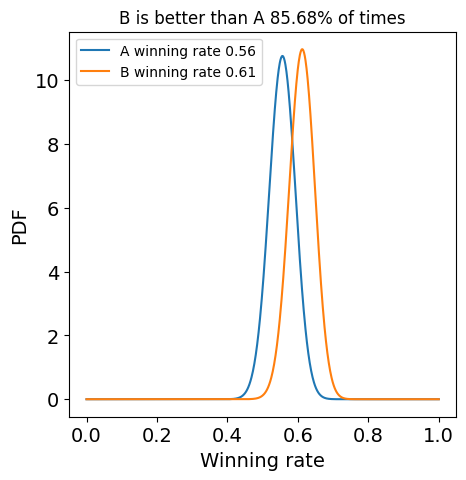

In [3]:
plot_distributions(100, 80, 110, 70)
plt.savefig("dist_a.svg", bbox_inches='tight', transparent=True)

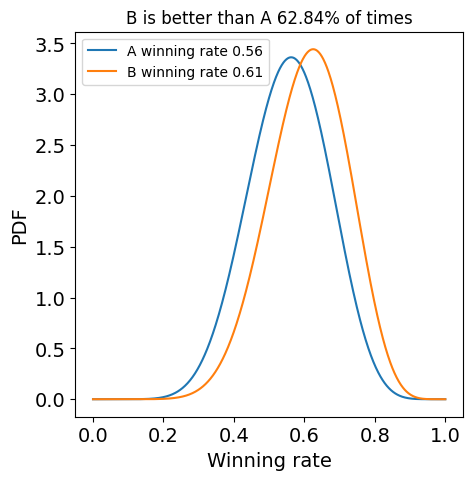

In [4]:
plot_distributions(10, 8, 11, 7)
plt.savefig("dist_b.svg", bbox_inches='tight', transparent=True)

# Read data

In [5]:
import pandas as pd
raw_headers = pd.read_parquet("../data/compacted/compact_data.parquet")

In [6]:
headers = raw_headers.copy()

# Process data

In [7]:
headers = clean_headers_dataframe(headers)

In [8]:
headers['white_points'] = headers['Result'].map(result_to_points)
headers['black_points'] = 1 - headers['white_points']

In [9]:
headers['time_control'] = headers['TimeControl'].map(assign_time_control)

In [10]:
headers['pos'] = headers['FEN'].map(lambda x: x[:8])
headers['month'] = headers['UTCDate'].map(lambda x: x[0:7])
headers['month'] = pd.to_datetime(headers['month'])

In [11]:
# create groups of ELO with a width of 300 points
headers['white_elo_round'] = headers['WhiteElo'].apply(lambda x: custom_round(x, base=300))
headers['black_elo_round'] = headers['BlackElo'].apply(lambda x: custom_round(x, base=300))

# Select the biggest group

In [12]:
sample = headers[headers['white_elo_round'] == headers['black_elo_round']]

In [13]:
sample.value_counts(['time_control', 'white_elo_round']).head(1)

time_control  white_elo_round
blitz         1800               2370742
dtype: int64

In [14]:
TIME_CONTROL = 'blitz'
ELO = 1800

In [15]:
sample = sample[sample['time_control'] == TIME_CONTROL]
sample = sample[sample['white_elo_round'] == ELO]

# Train/Test split

In [16]:
split_date = "2022.06.01"
train = sample[sample['UTCDate'] < split_date]
test = sample[sample['UTCDate'] >= split_date]

In [17]:
len(test) / len(sample)

0.2023358087889783

# Aggregate stats

In [18]:
train_g = group_fens(train)
test_g = group_fens(test)

In [19]:
train_comp = generate_comparisons(train_g, 30)
test_comp = generate_comparisons(test_g, 960)

In [20]:
# for each pair compute the probability that one beats the other

def f(row):
    return prob_b_beats_a(int(row['won_low']), 
                          int(row['lost_low']), 
                          int(row['won_top']), 
                          int(row['lost_top']))
train_comp['prob_win'] = train_comp.apply(f, axis=1)
train_comp['alpha'] = 1 - train_comp['prob_win']

# Analyze most extreme case

In [21]:
train_comp.sort_values('alpha').head(1)

,pos_low,won_low,lost_low,count_low,rate_low,pos_top,won_top,lost_top,count_top,rate_top,prob_win,alpha
29,rnnqbkrb,929,1034,1963,0.473255,bbrqnkrn,1082,893,1975,0.547848,0.999999,0.000001


In [22]:
low_pos = "rnnqbkrb"
top_pos = "bbqnnrkr"

In [23]:
test_comp[(test_comp['pos_low'] == low_pos) & (test_comp['pos_top'] == top_pos)]

,pos_low,won_low,lost_low,count_low,rate_low,pos_top,won_top,lost_top,count_top,rate_top
532735,rnnqbkrb,261,241,502,0.51992,bbqnnrkr,292,242,534,0.546816


# Plots of past vs future rates

[[1.         0.00291572]
 [0.00291572 1.        ]]


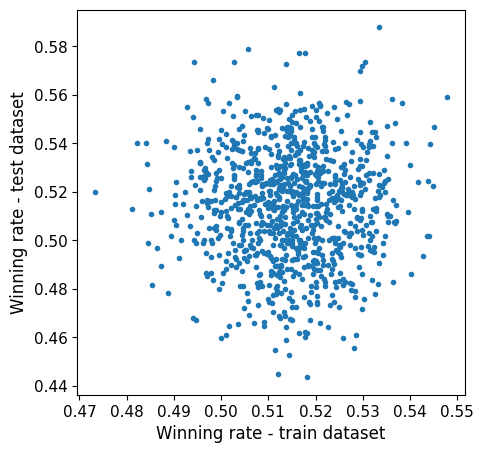

In [24]:

m = train_g.merge(test_g, on='pos')
x = m['rate_x']
y = m['rate_y']

plt.figure(figsize=(5,5))
plt.plot(x, y, '.')
plt.xlabel("Winning rate - train dataset", size=12)
plt.ylabel("Winning rate - test dataset", size=12)
plt.xticks(size=11)
plt.yticks(size=11)
plt.savefig("test-vs-train.svg", bbox_inches='tight', transparent=True)

print(np.corrcoef(x, y))

# Stockfish vs Reality

In [25]:
sf = pd.read_csv("../data/stockfish_evaluations.csv")

In [26]:
m = train_g.merge(sf, left_on='pos', right_on='variation')

[[1.         0.03048642]
 [0.03048642 1.        ]]


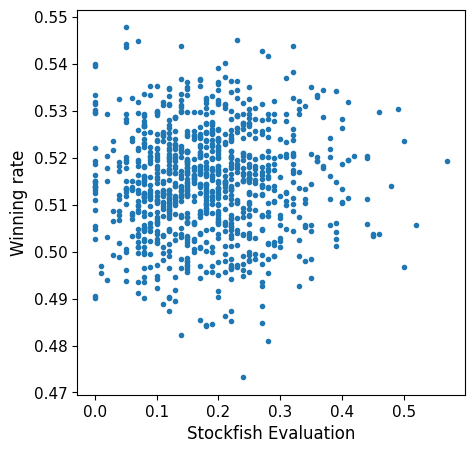

In [27]:
eval = m['evaluation']
rate = m['rate']

plt.figure(figsize=(5, 5))
plt.plot(eval, rate, '.')

plt.xlabel("Stockfish Evaluation", size=12)
plt.ylabel("Winning rate", size=12)
plt.xticks(size=11)
plt.yticks(size=11)
plt.savefig("eval-vs-rate.svg", bbox_inches='tight', transparent=True)

print(np.corrcoef(eval, rate))